In [ ]:
# Lasso regression to predict "Arrests" boolean
# Dataset: crimes + poverty
# Performs sampling of data to obtains small subsets to run faster
# Perfoms one hot encoding
# Prunes execessive features with minimal drop in R2

In [1]:
import pandas as pd
from dask import dataframe as dk
import numpy as np
#!pip install pandas --upgrade
data_types = {
    'ID':  np.int64,
    'Case Number':  object,
    'Date': object,
    'Block': object,
    'IUCR': object,
    'Primary Type': object,
    'Description':  object,
    'Location Description': object,
    'Arrest':  bool,
    'Domestic': bool,
    'Beat': np.int64,
    'District': np.float64,
    'Ward': np.float64,
    'Community Area': np.float64,
    'FBI Code': object,
    'X Coordinate': np.float64,
    'Y Coordinate': np.float64,
    'Year': np.int64,
    'Updated On': object,
    'Latitude': np.float64,
    'Longitude': np.float64,
    'Location': object
}
df = pd.read_csv('crimes.csv', dtype=data_types)

In [2]:
poverty = pd.read_csv('poverty.csv')
poverty = poverty.drop('COMMUNITY AREA NAME', 1)
poverty.head()

,Community Area Number,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,7.8,17.2,8.8,20.8,38.5,23040,46.0
2,3.0,3.8,24.0,8.9,11.8,22.2,35787,20.0
3,4.0,3.4,10.9,8.2,13.4,25.5,37524,17.0
4,5.0,0.3,7.5,5.2,4.5,26.2,57123,6.0


In [122]:
#  Remove unwanted columns from the data
# Add 'Date' back in when RJ fixes the datetime converter
useful_columns = ['IUCR', 'Arrest', 'Community Area', 'Year']
data_full = df[useful_columns]

In [123]:
# Merge with the poverty dataframe
data_full = data_full.rename(columns={'Community Area': 'Community Area Number'})
data_full = pd.merge(data_full, poverty, how='right', on='Community Area Number')

In [124]:
# Also resample to a smaller size for now
num_records = 100000
data = data_full.sample(num_records, replace=True)
data = data.dropna()
data.tail()

,IUCR,Arrest,Community Area Number,Year,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
1215354,1350,False,28.0,2008,3.8,20.6,10.7,9.6,22.2,44689,15.0
152956,1320,False,31.0,2012,9.6,25.8,15.8,40.7,32.6,16444,76.0
5273720,0840,False,70.0,2004,4.0,10.4,11.7,17.7,36.9,23482,37.0
4250444,1320,False,16.0,2012,6.3,13.1,10.0,22.4,31.6,27249,34.0
530878,5002,False,69.0,2015,3.6,29.6,23.0,16.5,41.0,17285,66.0


In [125]:
# Get a smaller subset of the crimes.
# Domestic Battery Simple 0486
battery = data[data['IUCR'] == '0486']

In [126]:
d_subset = battery
dummy_vars = ['Year', 'Community Area Number']
# Takes about 2 minutes to run on all records, takes much less time to run on subset of 1 or 2 million
battery = pd.get_dummies(d_subset, columns=dummy_vars, drop_first=True, sparse=True)
battery.head()

,IUCR,Arrest,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX,Year_2002,...,Community Area Number_68.0,Community Area Number_69.0,Community Area Number_70.0,Community Area Number_71.0,Community Area Number_72.0,Community Area Number_73.0,Community Area Number_74.0,Community Area Number_75.0,Community Area Number_76.0,Community Area Number_77.0
2565318,0486,True,7.4,43.1,21.2,27.6,42.7,12034,87.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373852,0486,False,1.9,12.9,7.0,2.5,22.6,88669,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3848151,0486,False,8.2,42.4,19.6,21.3,43.2,12961,83.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1415720,0486,True,3.3,27.8,24.0,14.5,40.3,18881,60.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4702629,0486,True,9.4,41.7,25.8,24.5,43.6,10934,92.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
from sklearn.cross_validation import train_test_split

dep_var = ['Arrest']
indep_var = battery.columns.values
indep_var = [x for x in indep_var if x not in dep_var]
X = battery[indep_var]
y = battery[dep_var]
# Split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [128]:
X_train.shape

(4931, 99)

In [129]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
# C = 0.001 found through cross validation
logr = LogisticRegression(C=0.001, class_weight='balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
logr.fit(X_train, y_train)

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [130]:
logr.score(X_test, y_test)

0.58312757201646093

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Arrest', 'Arrest'], rotation=45)
    plt.yticks(tick_marks, ['No Arrest', 'Arrest'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_roc(model):
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)
    predictions = [x[1] for x in predictions]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


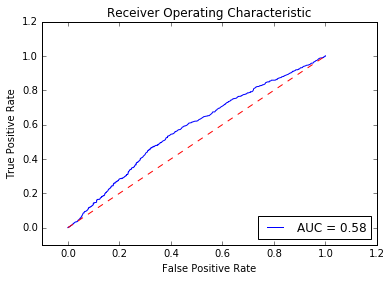

In [132]:
# ROC curve
logr.fit(X_train, y_train)
prediction = logr.predict(X_test)
plot_roc(logr)

[[1093  742]
 [ 271  324]]


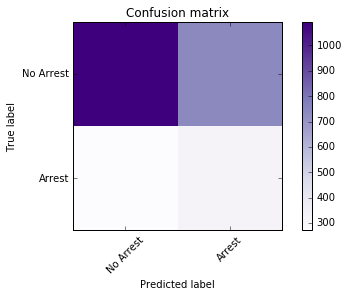

In [133]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, cmap=plt.cm.Purples)

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')

In [135]:
rf.fit(X_train, y_train)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [136]:
rf.score(X_test, y_test)

0.59012345679012346

In [137]:
# Order of importance
fi = zip(X_train.columns, rf.feature_importances_)
fi_sort = sorted(fi, key=lambda (x,y): y, reverse=True)
fi_sort

[('Year_2005', 0.050488913010915876),
 ('Year_2003', 0.048725871173779398),
 ('Year_2008', 0.048283847559865506),
 ('Year_2010', 0.04733060511952767),
 ('Year_2009', 0.045489910603829432),
 ('Year_2012', 0.043981907489800423),
 ('PERCENT AGED UNDER 18 OR OVER 64', 0.043567709333557421),
 ('Year_2015', 0.043009961520743482),
 ('Year_2004', 0.041613702783679353),
 ('Year_2006', 0.040738170591411833),
 ('PERCENT AGED 16+ UNEMPLOYED', 0.039846701035558874),
 ('Year_2007', 0.038449065319704129),
 ('Year_2002', 0.038087384685855707),
 ('Year_2011', 0.037978870638629356),
 ('PERCENT HOUSEHOLDS BELOW POVERTY', 0.03744954840088615),
 ('Year_2013', 0.037356275713785726),
 ('PERCENT OF HOUSING CROWDED', 0.037015417212374363),
 ('Year_2014', 0.036751400684228948),
 ('HARDSHIP INDEX', 0.036631647041590297),
 ('PER CAPITA INCOME ', 0.036613776055767822),
 ('PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', 0.036087588103967845),
 ('Year_2016', 0.025148445278135832),
 ('Community Area Number_67.0', 0.00

In [147]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(class_weight='balanced')
model = AdaBoostClassifier(dt, n_estimators=10, learning_rate=.1)
model.fit(X_train, y_train)

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=10, random_state=None)

[[1036  799]
 [ 301  294]]


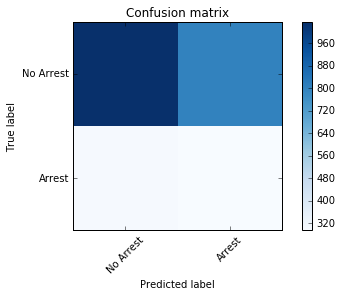

In [148]:
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm)

In [149]:
model.score(X_test, y_test)

0.54732510288065839

In [151]:
# Order of importance
fi = zip(X_train.columns, model.feature_importances_)
fi_sort = sorted(fi, key=lambda (x,y): y, reverse=True)
fi_sort

[('PERCENT AGED 16+ UNEMPLOYED', 0.16613052298711917),
 ('PER CAPITA INCOME ', 0.056563739348425457),
 ('PERCENT AGED UNDER 18 OR OVER 64', 0.051535883243361613),
 ('Year_2008', 0.051396148941482075),
 ('Year_2013', 0.047176444929087888),
 ('PERCENT HOUSEHOLDS BELOW POVERTY', 0.045367565047580848),
 ('PERCENT OF HOUSING CROWDED', 0.044604880191579682),
 ('Year_2010', 0.043753976473499455),
 ('HARDSHIP INDEX', 0.038501587245163296),
 ('PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', 0.036897634592147684),
 ('Year_2012', 0.035256417689344122),
 ('Year_2009', 0.035063241563188081),
 ('Year_2014', 0.033512022934400656),
 ('Year_2005', 0.033331701035510961),
 ('Year_2011', 0.03115923239178987),
 ('Year_2006', 0.028294218892012994),
 ('Year_2002', 0.027291180114929224),
 ('Year_2015', 0.026759993110690616),
 ('Year_2003', 0.021813087290598963),
 ('Year_2007', 0.021195646145190837),
 ('Year_2004', 0.018106425673551467),
 ('Year_2016', 0.01674944270746085),
 ('Community Area Number_28.0', 0.016